In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,GRU, Flatten, SimpleRNN

In [2]:
signal=lambda t: np.sin(np.pi*t)
INTERVAL_START=0
INTERVAL_END=10

In [3]:
def get_signal_values_timed(delta_t, k):
    values=[]
    time_points=[]
    steps=int((INTERVAL_END-INTERVAL_START)/delta_t)
    for t in np.linspace(INTERVAL_START, INTERVAL_END, steps):
        values.append(signal(t))
        time_points.append(t)
    values=np.array([0]*(k-1)+values+[0]*k)
    dataset=timeseries_dataset_from_array(values[:-k], values[k:], sequence_length=k)
    X,y=None, None
    for batch in dataset:
        if X is None or y is None:
            X,y=batch[0].numpy(), batch[1].numpy()
        else:
            X=np.concatenate((X, batch[0].numpy()))
            y=np.concatenate((y, batch[1].numpy()))
    return X, y, time_points

In [4]:
def create_fully_connected_model(k):
    network = Sequential()
    network.add(Dense(512, activation='relu', input_shape=(k,)))
    network.add(Dense(256, activation='relu'))
    network.add(Dense(128, activation='relu'))
    network.add(Dense(64, activation='relu'))
    network.add(Dense(1, activation='linear'))
    network.compile(optimizer='adam',
                    loss='mse')
    return network

In [5]:
def create_rnn_model(k):
    lstm_model = Sequential()
    lstm_model.add(SimpleRNN(256, activation='relu', input_shape=(k, 1), return_sequences=True))
    lstm_model.add(SimpleRNN(128, activation='relu', return_sequences=True))
    lstm_model.add(SimpleRNN(64, activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

In [11]:
def plot_history(histories):
    for (k, history) in histories:
        plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
        plt.title(f'Evaluation of model k={k}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.legend()    
        plt.show()

In [7]:
def plot_predictions(predictions, model_name='Model'):
    fig=plt.figure(figsize=(10, 20), dpi= 100, facecolor='w', edgecolor='k')
    for i,(k, time_points, y_predicted, y_true) in enumerate(predictions):
        ax = fig.add_subplot(len(predictions), 1, 1 + i)
        ax.set_title(f"k={k}")
        ax.plot(time_points, y_predicted.flatten(), label="Predicted")
        ax.plot(time_points, y_true, '*', label="Actual")
        ax.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [8]:
def train_validation_test_split(X, y, val_size, test_size):
    val_size=int(X.shape[0]*val_size)
    test_size=int(X.shape[0]*test_size)
    tscv=TimeSeriesSplit(n_splits=2, test_size=test_size)
    train_index, test_index = list(tscv.split(X))[-1]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    tscv=TimeSeriesSplit(n_splits=2, test_size=val_size)
    train_index, val_index = list(tscv.split(X_train))[-1]
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
def evaluate_model(create_model, get_signal_values_timed):
    histories=[]
    predictions=[]
    for k in range(3, 8):
        X,y, time_points=get_signal_values_timed(0.05, k) 
        model=create_model(k)
        callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
        ]
        X_train, y_train, X_val, y_val, X_test, y_test=train_validation_test_split(X, y, 0.25, 0.25)
        model.fit(X,y,validation_data=(X_val, y_val),epochs=500, verbose=0, callbacks=callbacks)
        histories.append((k, model.history))
        y_predicted=model.predict(X_test)
        predictions.append((k, time_points[-X_test.shape[0]:], y_predicted, y_test))
    plot_predictions(predictions)
    plot_history(histories)

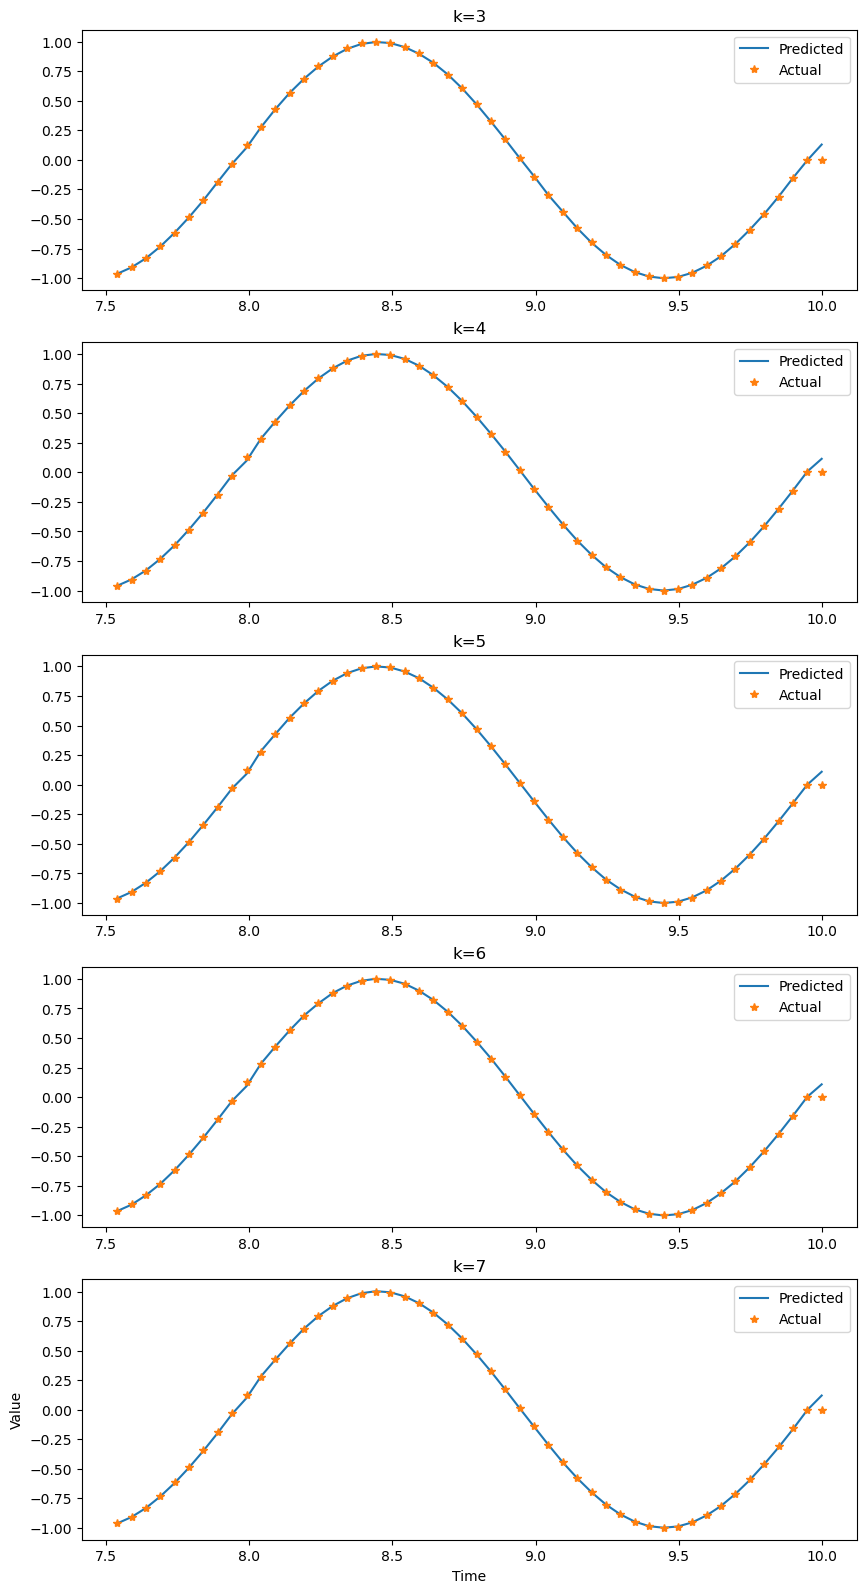

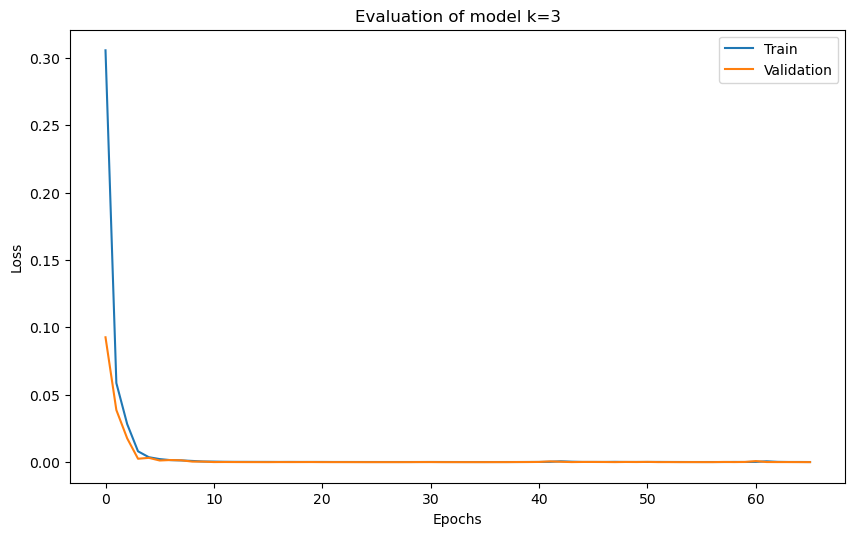

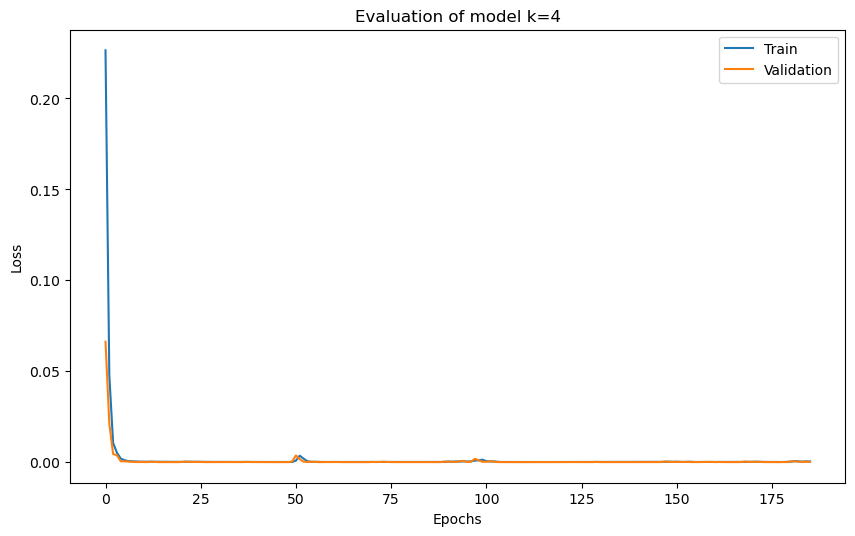

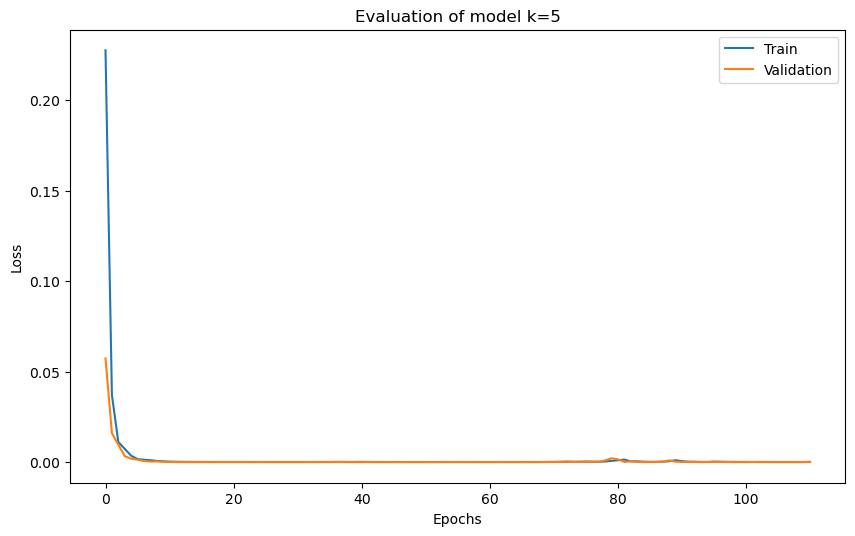

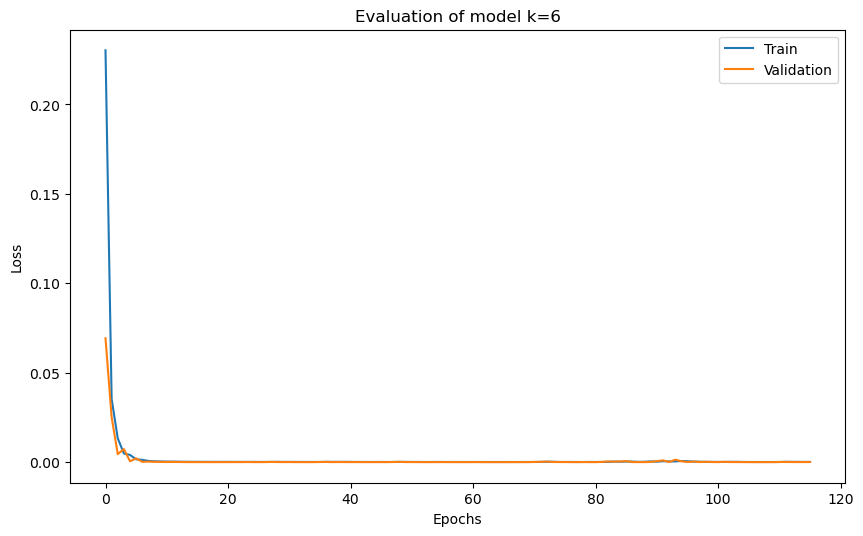

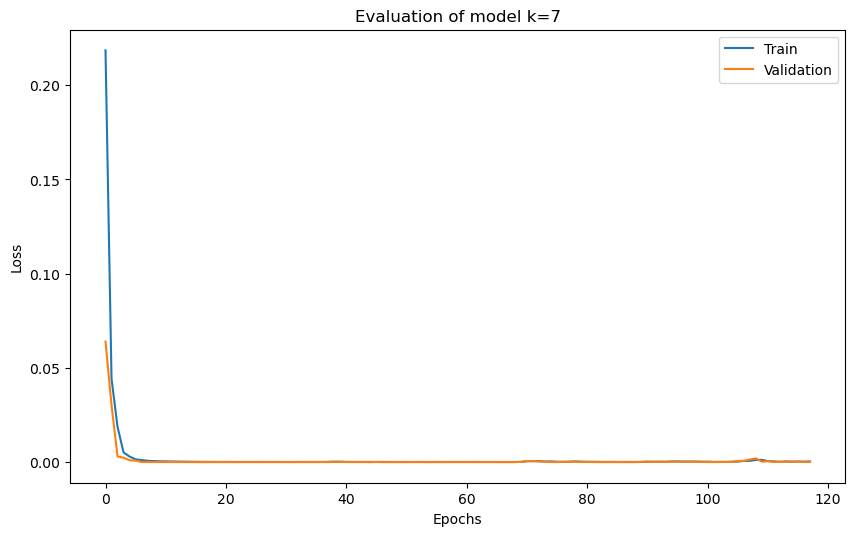

In [12]:
evaluate_model(create_fully_connected_model, get_signal_values_timed)

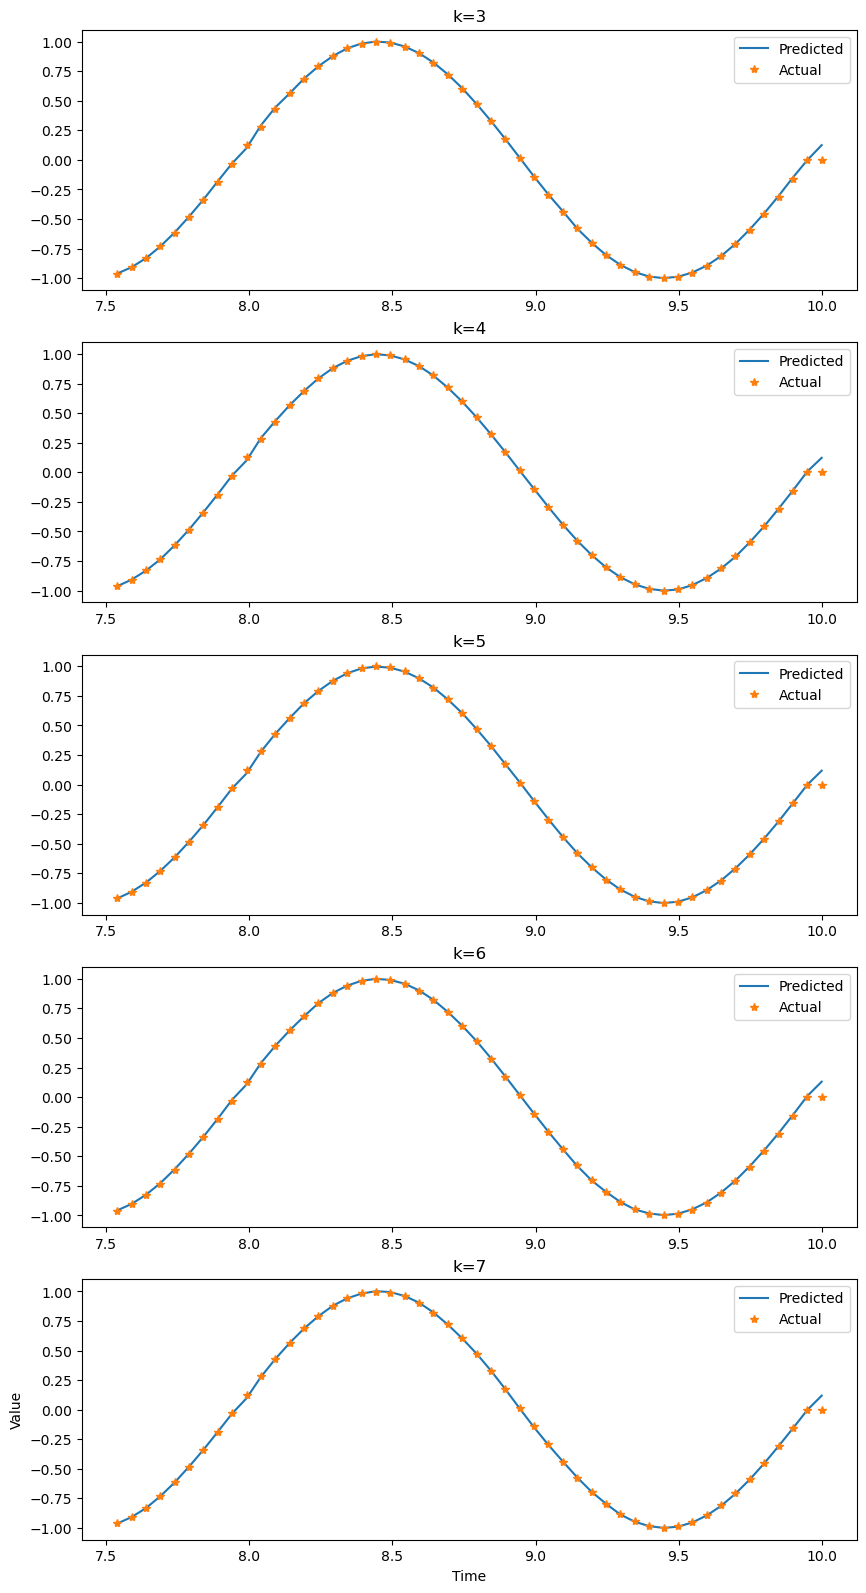

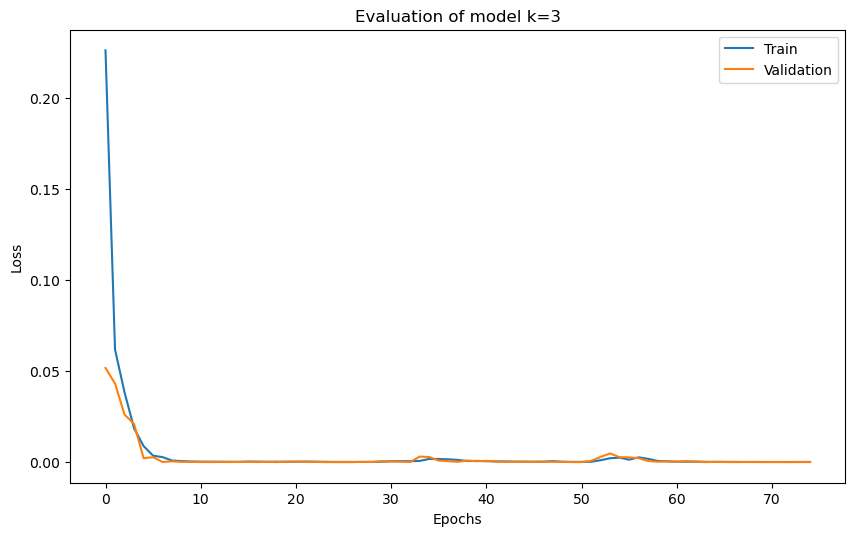

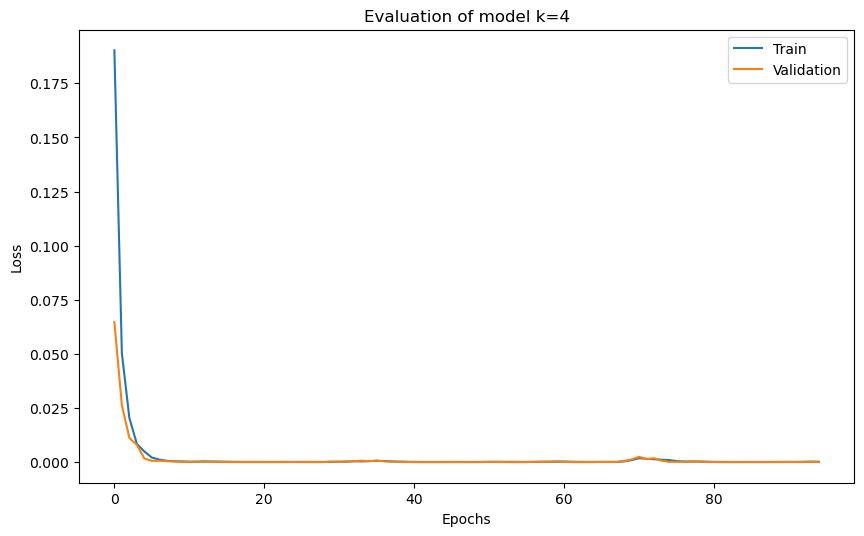

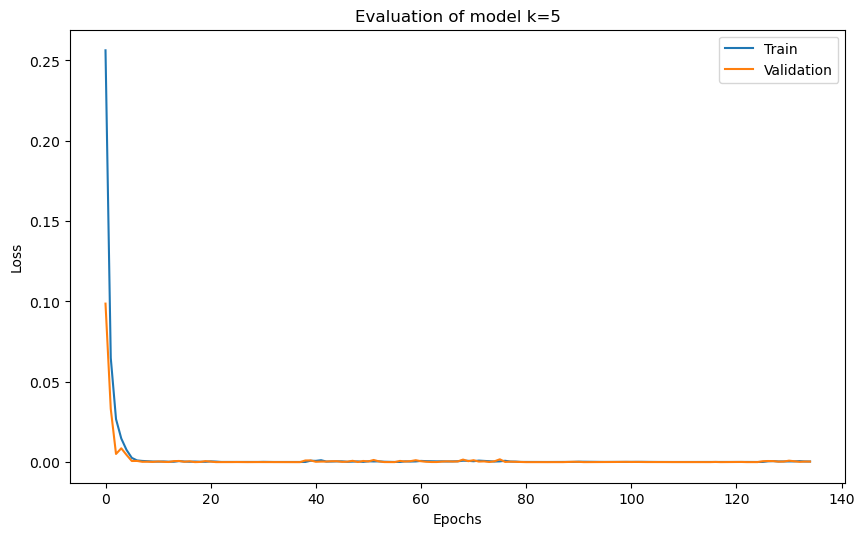

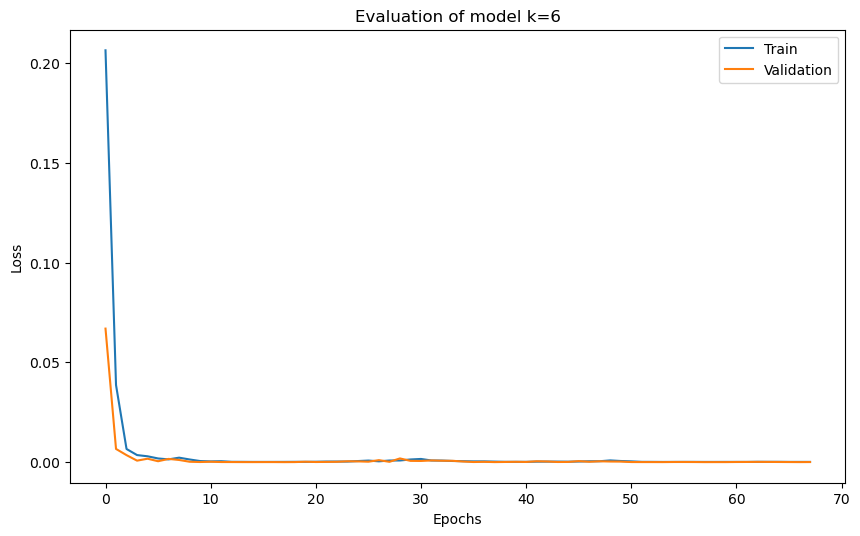

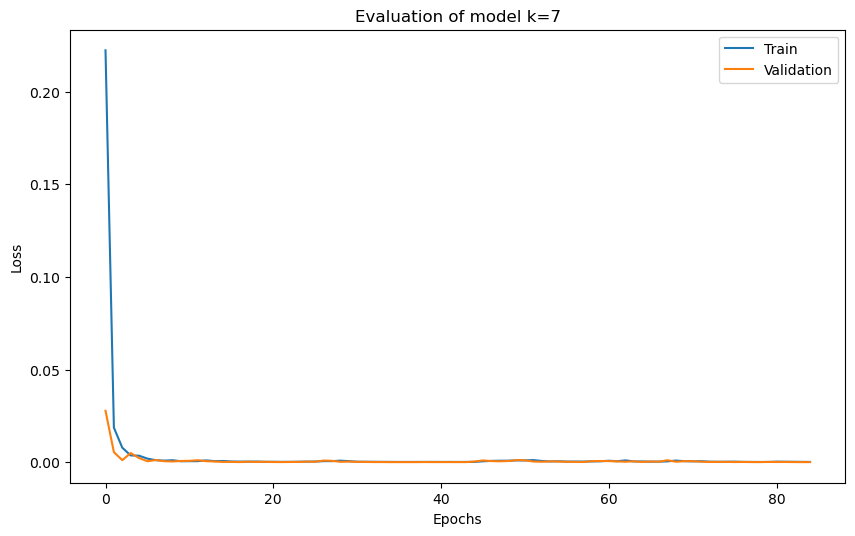

In [13]:
def to_rnn_format(X, y):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

def get_signal_values_timed_rnn(delta_t, k):
    X,y,time_points=get_signal_values_timed(delta_t, k)
    return *to_rnn_format(X,y), time_points

    
evaluate_model(create_rnn_model, get_signal_values_timed_rnn)

In [14]:
def create_lstm_model(k):
    lstm_model = Sequential()
    lstm_model.add(LSTM(256, activation='relu', input_shape=(k, 1), return_sequences=True))
    lstm_model.add(LSTM(128, activation='relu', return_sequences=True))
    lstm_model.add(LSTM(64, activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

In [15]:
jena_csv=pd.read_csv("data/jena_climate_2009_2016.csv")

In [16]:
jena_csv["Date"]=jena_csv["Date Time"].apply(lambda row: datetime.strptime(row, "%d.%m.%Y %H:%M:%S").date())

In [17]:
min_temperatures=[]
for (_,group) in jena_csv.groupby("Date"):
    min_temperatures.append(group['T (degC)'].min())

In [22]:
def get_temperatures_time_series(k, temperatures):
    temperatures=np.array(temperatures)
    dataset=timeseries_dataset_from_array(temperatures[:-k], temperatures[k:], sequence_length=k)
    X,y=None, None
    for batch in dataset:
        if X is None or y is None:
            X,y=batch[0].numpy(), batch[1].numpy()
        else:
            X=np.concatenate((X, batch[0].numpy()))
            y=np.concatenate((y, batch[1].numpy()))
    return X, y

def to_lstm_format(X, y):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

def get_temperatures_time_series_lstm(k, temperatures):
    X,y=get_temperatures_time_series(k, temperatures)
    return to_lstm_format(X,y)

In [19]:
def plot_predictions_jena(predictions, model_name='Model'):
    fig=plt.figure(figsize=(10, 20), dpi= 100, facecolor='w', edgecolor='k')
    for i,(k, time_points, y_predicted, y_true) in enumerate(predictions):
        ax = fig.add_subplot(len(predictions), 1, 1 + i)
        ax.set_title(f"k={k}")
        ax.plot(time_points, y_predicted.flatten(), 'o', label="Predicted")
        ax.plot(time_points, y_true, '*', label="Actual")
        ax.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [20]:
def evaluate_jena_model(create_model, min_temperatures, get_temperatures_time_series):
    histories=[]
    predictions=[]
    for k in range(3, 8):
        X,y=get_temperatures_time_series(k, min_temperatures)
        X_train, y_train, X_val, y_val, X_test, y_test=train_validation_test_split(X, y, 0.2, 0.2)
        model=create_model(k)
        callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
        ]
        model.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=500, verbose=0,callbacks=callbacks)
        histories.append((k, model.history))
        y_predicted=model.predict(X_test)
        print(f"Score for k={k}")
        score=model.evaluate(X_test, y_test)
        predictions.append((k, np.arange(0, y_test.shape[0], 1), y_predicted, y_test))
    plot_predictions_jena(predictions)
    plot_history(histories)

Score for k=3
19/19 [==============================] - 0s 684us/step - loss: 7.1678
Score for k=4
19/19 [==============================] - 0s 629us/step - loss: 7.2740
Score for k=5
19/19 [==============================] - 0s 630us/step - loss: 7.2674
Score for k=6
19/19 [==============================] - 0s 737us/step - loss: 7.1652
Score for k=7
19/19 [==============================] - 0s 686us/step - loss: 7.4243


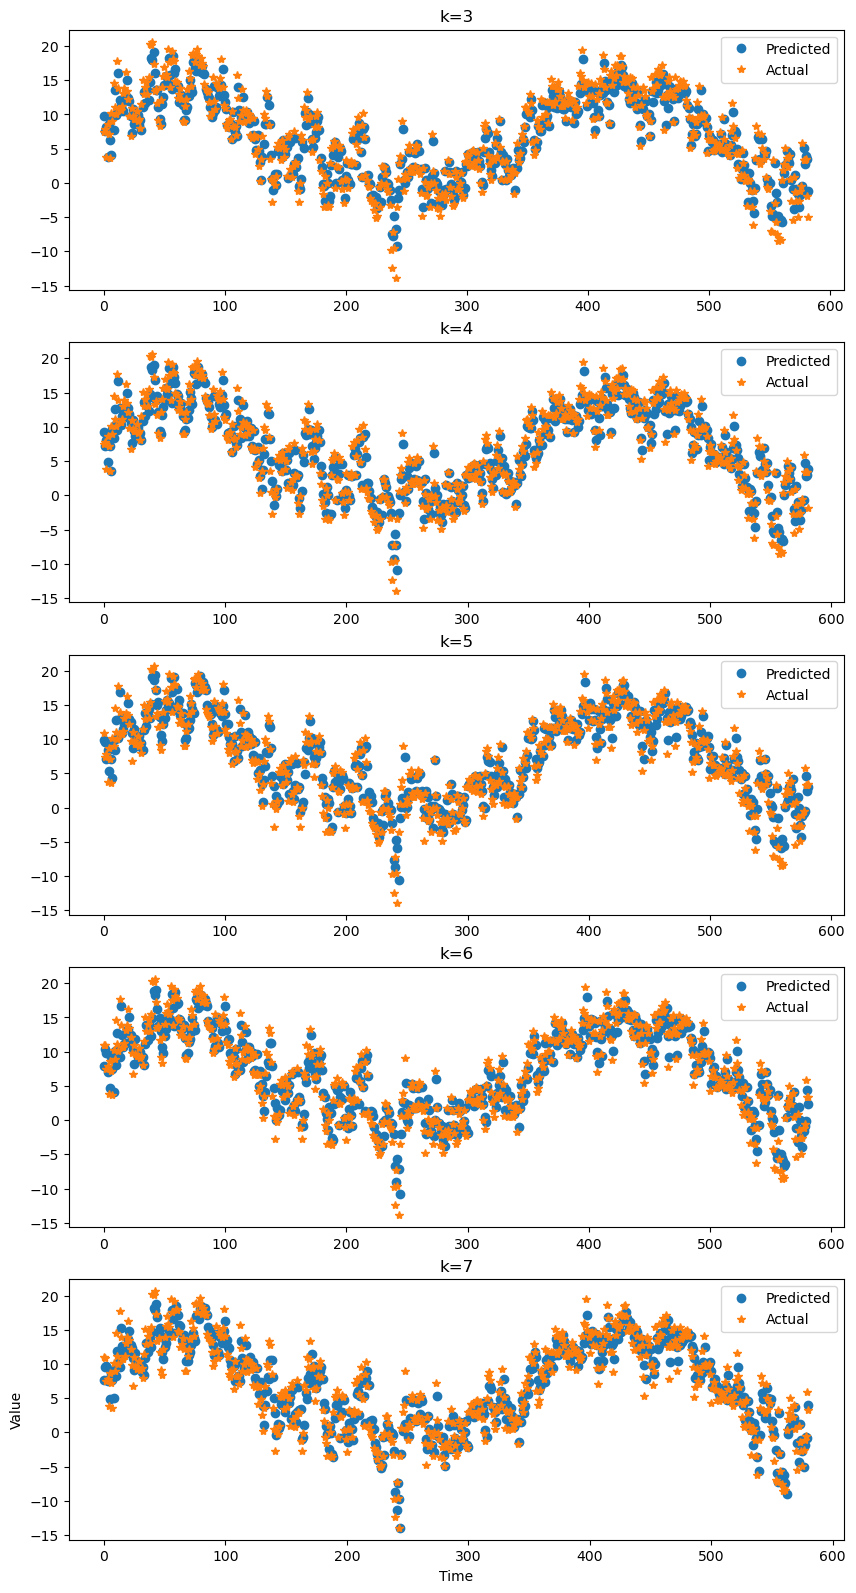

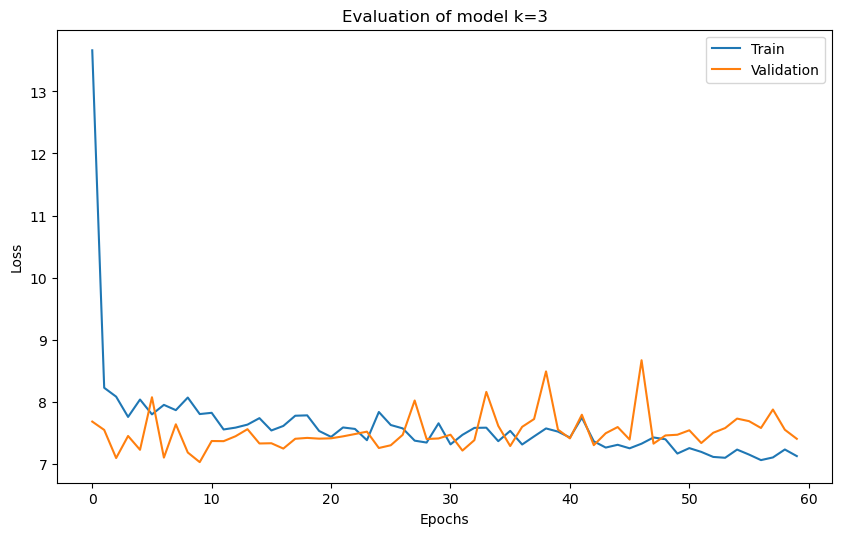

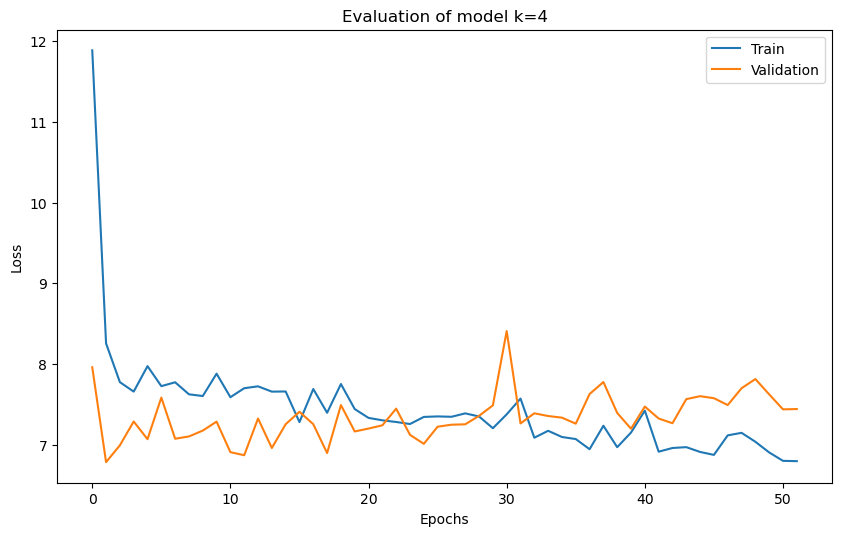

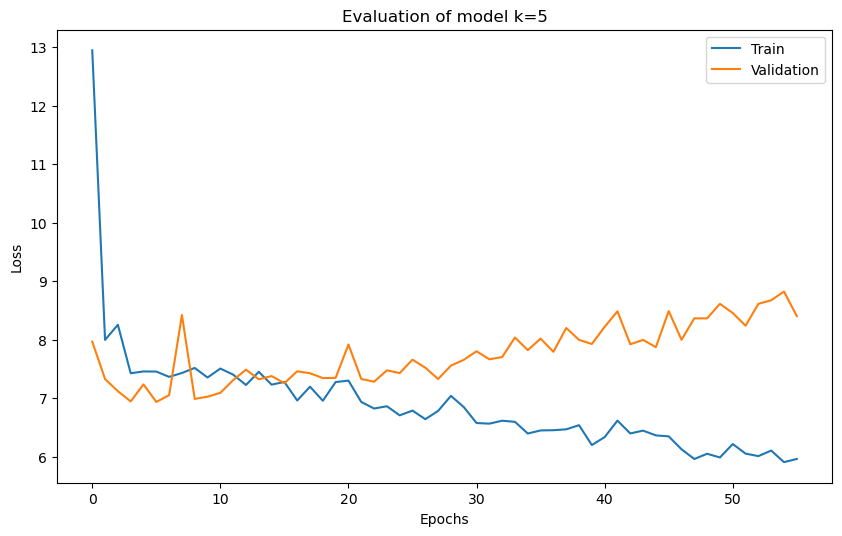

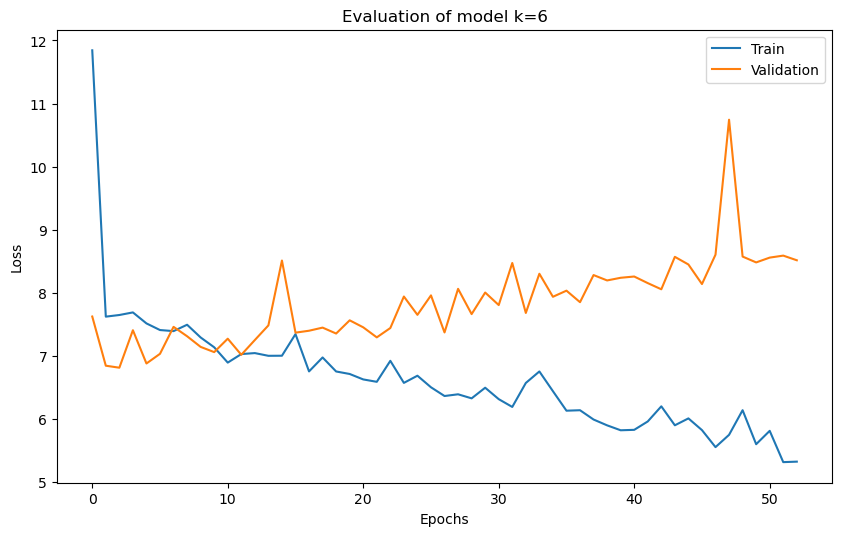

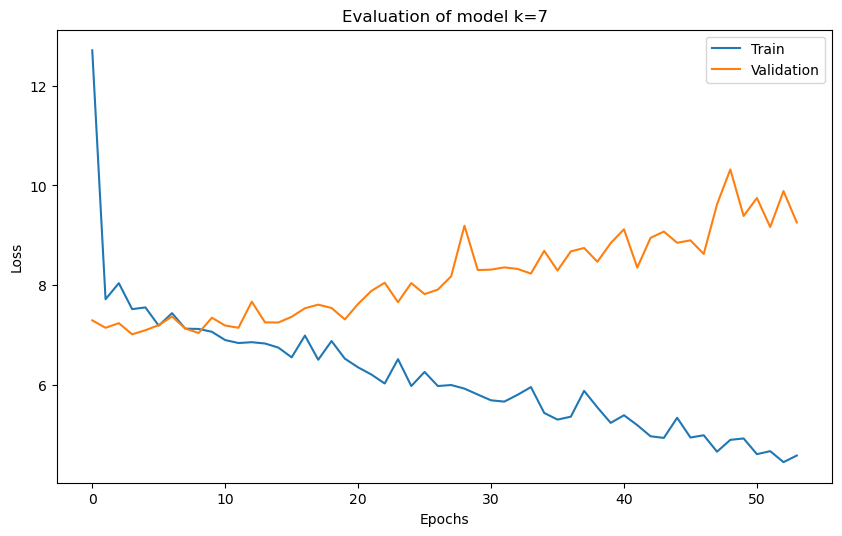

In [21]:
evaluate_jena_model(create_fully_connected_model, min_temperatures,get_temperatures_time_series)

Score for k=3
19/19 [==============================] - 0s 3ms/step - loss: 7.1261
Score for k=4
19/19 [==============================] - 0s 4ms/step - loss: 7.3036
Score for k=5
19/19 [==============================] - 0s 4ms/step - loss: 7.2361
Score for k=6
19/19 [==============================] - 0s 5ms/step - loss: 7.3605
Score for k=7
19/19 [==============================] - 0s 5ms/step - loss: 7.2540


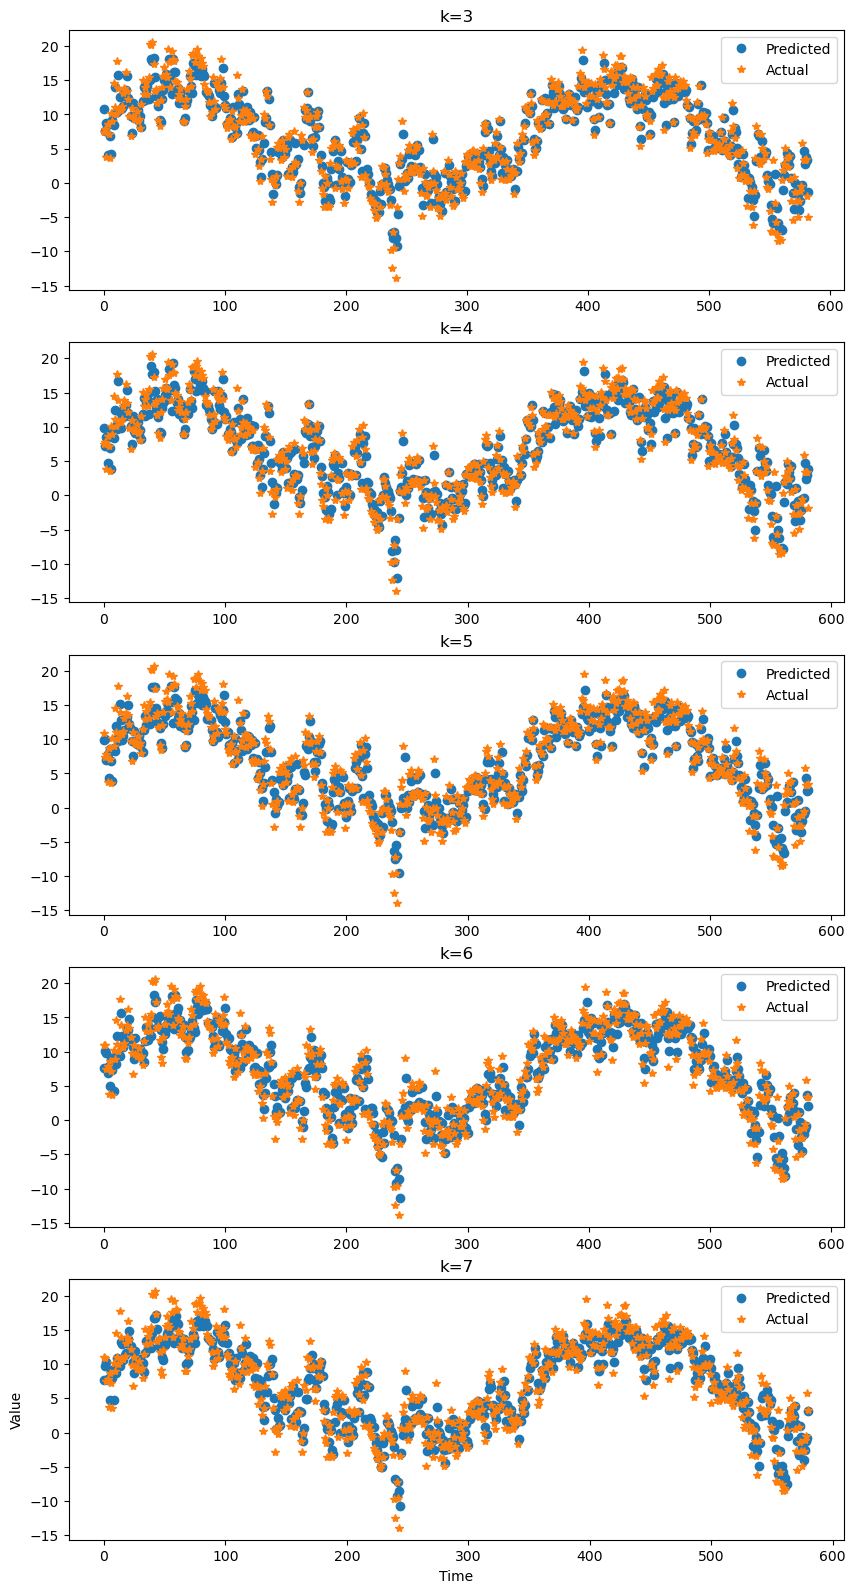

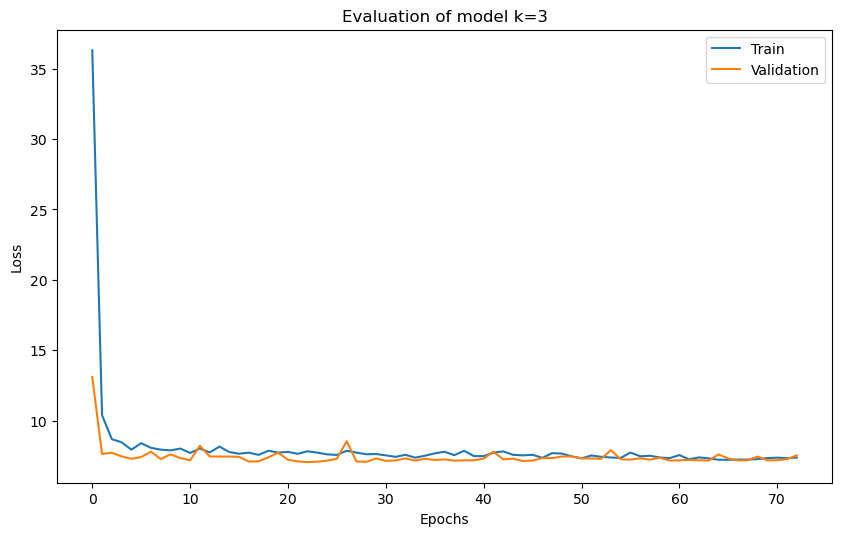

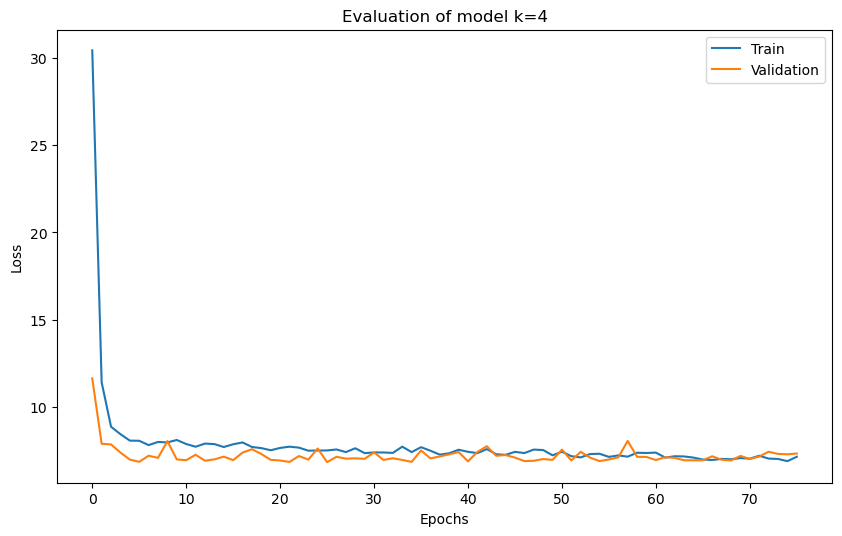

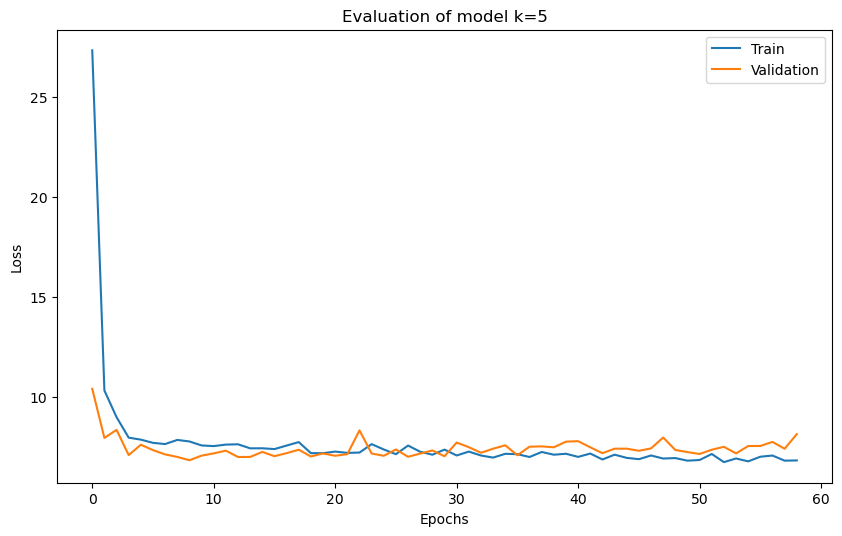

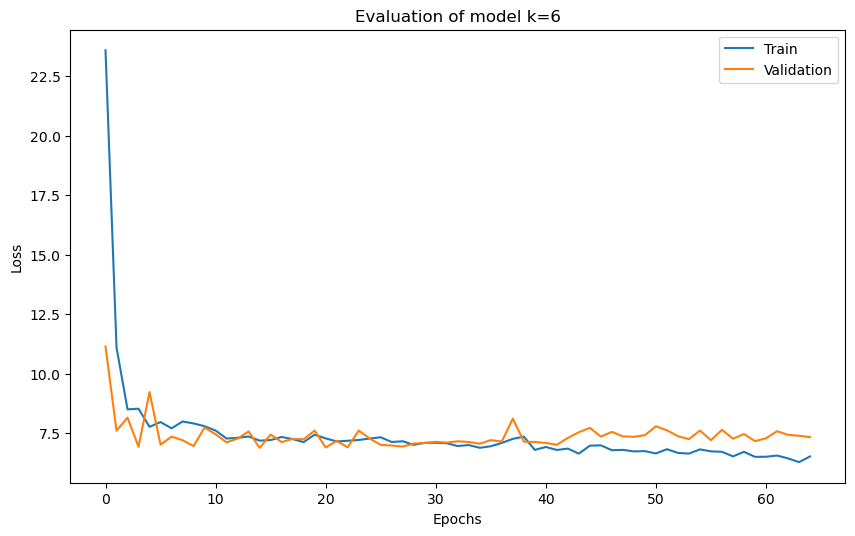

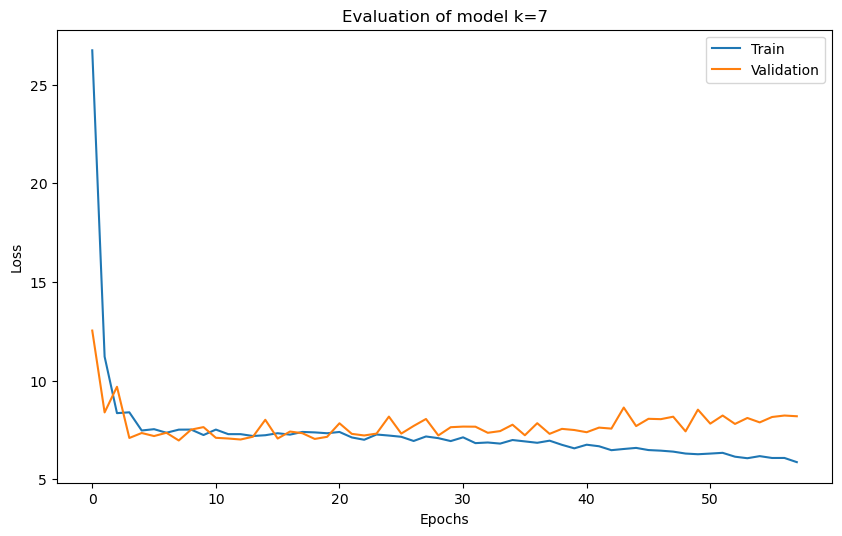

In [23]:
evaluate_jena_model(create_lstm_model, min_temperatures,get_temperatures_time_series_lstm)